In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load files
train = pd.read_csv('../data/gender_age_train.csv')
test = pd.read_csv('../data/gender_age_test.csv')

In [4]:
train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [5]:
test.head()

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


In [6]:
print len(test) > len(train)

True


In [19]:
data = pd.concat([train, test], axis=0)

** More records in the test set than there are in the training set **

###  Question 1 Are there any device ids in test set that are also present in the training set 

In [7]:
print any(pd.Series(test.device_id.unique()).isin(train.device_id))

False


** So there are no device ids which are in test as well as train ids. **

In [8]:
train.device_id.value_counts().describe()

count    74645.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: device_id, dtype: float64

In [9]:
test.device_id.value_counts().describe()

count    112071.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: device_id, dtype: float64

** No duplicate records for any record id in train as well as test set. **

In [13]:
train.gender.value_counts()

M    47904
F    26741
Name: gender, dtype: int64

** More males than females in the training set. **

In [19]:
train.age.describe()

count    74645.000000
mean        31.410342
std          9.868735
min          1.000000
25%         25.000000
50%         29.000000
75%         36.000000
max         96.000000
Name: age, dtype: float64

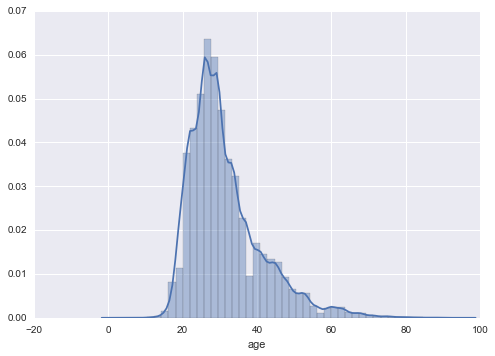

In [16]:
sns.distplot(train.age);

** Minimum age recorded is 1 and Maximum age recorded is 96. Need to look into this to see if this need to be corrected. **

In [22]:
train.group.value_counts()

M23-26    9605
M32-38    9476
M39+      8581
M22-      7488
M29-31    7309
F33-42    5561
M27-28    5445
F23-      5050
F29-32    4628
F43+      4194
F24-26    4190
F27-28    3118
Name: group, dtype: int64

** Distribution of target variable ( Multi-Class Classification ) problem. **

### Phone Brand Model

In [10]:
phone_brand_model = pd.read_csv('../data/phone_brand_device_model.csv')
phone_brand_model = phone_brand_model.drop_duplicates('device_id')
phone_brand_model.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [90]:
data_model_merged = pd.merge(data, phone_brand_model, on='device_id', how='left'); data_model_merged.head()

,age,device_id,gender,group,phone_brand,device_model
0,35.0,-8076087639492063270,M,M32-38,小米,MI 2
1,35.0,-2897161552818060146,M,M32-38,小米,MI 2
2,35.0,-8260683887967679142,M,M32-38,小米,MI 2
3,30.0,-4938849341048082022,M,M29-31,小米,红米note
4,30.0,245133531816851882,M,M29-31,小米,MI 3


In [91]:
assert data_model_merged.shape[0] == data.shape[0]

### Does device's model has any effect on the group ?

In [25]:
device_groupby = data_model_merged.groupby(['device_model', 'group']).size().unstack().fillna(0)
device_groupby_percentage = (device_groupby / device_groupby.sum(axis=0)) * 100.

In [92]:
data_model_merged['count_device_model'] = data_model_merged.groupby(['device_model'])['group'].transform(lambda x: len(x))

In [93]:
data_model_merged.head()

,age,device_id,gender,group,phone_brand,device_model,count_device_model
0,35.0,-8076087639492063270,M,M32-38,小米,MI 2,1310
1,35.0,-2897161552818060146,M,M32-38,小米,MI 2,1310
2,35.0,-8260683887967679142,M,M32-38,小米,MI 2,1310
3,30.0,-4938849341048082022,M,M29-31,小米,红米note,7343
4,30.0,245133531816851882,M,M29-31,小米,MI 3,5699


** Device Model Names translated to English **

In [32]:
translation = pd.read_csv('../data/brands_translation.csv', encoding='utf-8'); translation.head()

,brand_name_chineese,brand_name_english
0,三星,samsung
1,天语,Ktouch
2,海信,hisense
3,联想,lenovo
4,欧比,obi


** Events generated from a device id with information regarding timestamp and location **

In [57]:
events = pd.read_csv('../data/events.csv', parse_dates=['timestamp']); events.head()

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [66]:
events['count_events'] = events.groupby(['device_id'])['event_id'].transform(lambda x: len(x))

In [110]:
data_model_merged = pd.merge(data_model_merged, events[['device_id', 'count_events']], on='device_id', how='left')
data_model_merged = data_model_merged.drop_duplicates()

In [112]:
assert data_model_merged.shape[0] == data.shape[0]

In [113]:
data_model_merged['count_events'] = data_model_merged.count_events.fillna(0)
data_model_merged['log_count_events'] = data_model_merged['count_events'].map(np.log1p)
data_model_merged.head()

,age,device_id,gender,group,phone_brand,device_model,count_device_model,count_events,log_count_events
0,35.0,-8076087639492063270,M,M32-38,小米,MI 2,1310,0.0,0.000000
1,35.0,-2897161552818060146,M,M32-38,小米,MI 2,1310,0.0,0.000000
2,35.0,-8260683887967679142,M,M32-38,小米,MI 2,1310,1.0,0.693147
3,30.0,-4938849341048082022,M,M29-31,小米,红米note,7343,0.0,0.000000
4,30.0,245133531816851882,M,M29-31,小米,MI 3,5699,0.0,0.000000


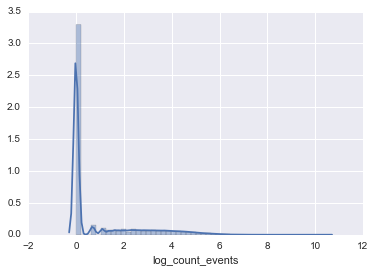

In [114]:
sns.distplot(data_model_merged.log_count_events);

In [115]:
train_processed = data_model_merged.loc[data_model_merged.group.notnull(), ['count_device_model', 'device_id', \
                                                                            'group', 'device_model',\
                                                                            'log_count_events']]
test_processed = data_model_merged.loc[data_model_merged.group.isnull(),['count_device_model', 'device_id', 
                                                                         'device_model', 'log_count_events']]

In [120]:
train_processed.to_csv('../processed/train_processed.csv', index=False)
test_processed.to_csv('../processed/test_processed.csv', index=False)

### Application Events

In [40]:
app_events = pd.read_csv('../data/app_events.csv'); app_events.head()`

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [42]:
app_labels = pd.read_csv('../data/app_labels.csv'); app_labels.head()

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [43]:
label_categories = pd.read_csv('../data/label_categories.csv'); label_categories.head()

,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time
